# 1. 사전작업
## 네이버에서 애널리스트 리포트 크롤링  & Text 처리


# 2. Text 데이터를 언어모델에 넣어 감성분석

사용한 모델은 KR-FinBert를 사용함 

하드웨어 M2 Mac 


In [ ]:

import os
import pandas as pd


import torch
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

# MPS 가속 지원 확인
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available and will be used.")
else:
    device = torch.device("cpu")
    print("MPS is not available. CPU will be used.")

# 모델 및 토크나이저 로드
model_name = "snunlp/KR-FinBert-SC"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).to(device)

# 파이프라인 설정 (추론만 진행)
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer, device=device)



/Users/sonhyeongjin/miniforge3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/sonhyeongjin/miniforge3/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <8E3FD81A-C2E9-3A49-B4B9-6094D47528A4> /Users/sonhyeongjin/miniforge3/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <ECC148AF-20FF-3EEE-BC75-4DD3E7455393> /Users/sonhyeongjin/miniforge3/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


MPS is available and will be used.


In [ ]:
import re
# 문장단위 감성분석을 위해 문장단위로 텍스트 처리 함수
def merge_sentences(text):
    lines = text.split('\n')
    merged_lines = []
    current_sentence = ""

    for line in lines:
        if re.search(r'\d', line):
            if current_sentence:
                merged_lines.append(current_sentence.strip())
            current_sentence = line
        else:
            current_sentence += " " + line

    if current_sentence:
        merged_lines.append(current_sentence.strip())
    
    return merged_lines


In [ ]:
import os
import pandas as pd
import unicodedata

# 애널리스트 리포트 들고오기 
input_folders = [
    "/Users/sonhyeongjin/Desktop/kai test2/DATA/20_21_txt_file",
    "/Users/sonhyeongjin/Desktop/kai test2/DATA/22_txt_file",
    "/Users/sonhyeongjin/Desktop/kai test2/DATA/23_txt_file",
    "/Users/sonhyeongjin/Desktop/kai test2/DATA/24_txt_file"

]

# 결과를 저장할 리스트 초기화
results = []

def cal_max(sentences): 
    sentences_length = []
    for i in sentences:
        sentences_length.append(len(i))
    max_cal = max(sentences_length)
    if max_cal > 512:
        return 512 #최대 길이 512로 설정
    else:
        return max_cal

# 모든 입력 폴더를 처리
for input_folder in input_folders:
    for filename in os.listdir(input_folder):
        if filename.endswith(".txt"):  # 텍스트 파일만 처리
            # 텍스트 파일 경로 설정
            file_path = os.path.join(input_folder, filename)

            # 파일 읽기
            with open(file_path, 'r', encoding='utf-8-sig') as file:
                content = file.read()

            # 텍스트를 문장 단위로 분할
            sentences = merge_sentences(content)

            # 긍정 점수의 합과 문장 수 초기화
            positive_score_sum = 0
            sentence_count = 0
            negative_score_sum = 0
            neutral_score_sum = 0
            max_1 = cal_max(sentences)

            # 각 문장에 대한 감성 분석 수행
            for sentence in sentences:
                sentence = sentence.strip()
                if sentence:  # 빈 문자열 제외
                    result = pipe(sentence[:max_1])  # 최대 길이 512로 제한 앞서 불러온 파이프 라인르로 결과 출력 
                    for r in result:
                        if r['label'] == 'positive':  # 긍정 감성일 경우
                            positive_score_sum += r['score']
                        elif r['label'] == 'negative':  # 부정 감성일 경우
                            negative_score_sum += r['score']
                        elif r['label'] == 'neutral':  # 중립 감성일 경우
                            neutral_score_sum += r['score']
                    sentence_count += 1

            # 문장의 평균 긍정 점수 계산
            if sentence_count > 0:
                average_positive_score = positive_score_sum / sentence_count
                average_negative_score = negative_score_sum / sentence_count
                average_neutral_score = neutral_score_sum / sentence_count
            else:
                average_positive_score = 0
                average_negative_score = 0
                average_neutral_score = 0

            # 파일 이름에서 날짜, 이름, 코드를 추출 (필요에 따라 정규식 사용 가능)
            dt, name_code = filename.split('_', 1)
            name, code = name_code.split('_code=', 1)
            code = code.split('_')[0]  # code 값만 추출

            # 결과 저장
            results.append([dt, name, code, average_positive_score, average_negative_score, average_neutral_score])

            # 진행 상황 출력
            print(f"'{filename}'에 대한 결과가 저장되었습니다.")

# 결과를 DataFrame으로 변환
df = pd.DataFrame(results, columns=["dt", "name", "code", "pos_score", "neg_score", "neu_score"])

# 정규화 함수 정의
def normalize_text(text):
    return unicodedata.normalize('NFC', text)

# 데이터프레임의 'name' 컬럼에 정규화 적용
df['name'] = df['name'].apply(normalize_text)

# DataFrame을 CSV 파일로 저장
# df.to_csv(output_csv, index=False, encoding='utf-8-sig')

# df.to_excel(output_excel, index=False, encoding='utf-8-sig')

print("데이터 처리가 완료되었습니다.")

In [76]:
df = pd.DataFrame(results, columns=["dt", "name", "code", "pos_score", "neg_score","neu_score"])

## Factor modeling을 위해 주가 데이터 들고오기 

In [ ]:
# Frd로 시장 데이터 들고오기
df_new = pd.read_csv('/Users/sonhyeongjin/Downloads/kr_finbert.csv') 
df_new.head()
df_new['code'] = df_new['code'].str.lstrip("'")

import pandas as pd
import FinanceDataReader as fdr

tickers = df_new['code'].unique().tolist()  
tickers = [str(ticker).zfill(6) for ticker in tickers]  
# 시작 날짜와 종료 날짜 설정
start_date = '2016-01-01'
end_date = '2024-08-06'

# 각 종목의 데이터를 가져와서 합치기
all_data = {}
error_list = []
for ticker in tickers:
    try:
        df = fdr.DataReader(ticker, start_date, end_date)
        all_data[ticker] = df['Close']
    except:
        error_list.append(ticker)

# 데이터프레임으로 변환
df_all = pd.DataFrame(all_data)



# df_all = pd.read_csv('/Users/sonhyeongjin/Desktop/kai test2/DATA/stock_data.csv')  # 시장데이터 
# df_all.head()

In [1]:
import pandas as pd

In [ ]:
df_anal = pd.read_csv('/Users/sonhyeongjin/Desktop/kai test2/DATA/전처리/손형진/data_2020_2024_son.csv') #2020년 부터 2024년까지 감성점수
df_anal_2 = pd.read_csv('/Users/sonhyeongjin/Desktop/kai test2/DATA/전처리/손형진/data_2016_2019_son.csv') # 2016년 부터 2019년까지 감성점수
df_anal = pd.concat([df_anal_2,df_anal])
df_all = pd.read_csv('/Users/sonhyeongjin/Desktop/kai test2/DATA/stock_data.csv') # 시장데이터 

In [80]:
df_all.set_index(df_all.columns[0], inplace=True)

In [ ]:
df_all.head()

,043370,041510,061970,030200,049950,053050,317400,019680,239340,119860,...,080530,004380,472850,300720,450140,475150,361570,240600,077970,000700
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,13900,41550,1520,28000,9260,1970,NaN,9100,NaN,5245,...,9444,8500,NaN,NaN,NaN,NaN,NaN,NaN,6860,7510
2016-01-05,13800,41850,1525,28200,9304,1920,NaN,8830,NaN,5270,...,8710,8500,NaN,NaN,NaN,NaN,NaN,NaN,7010,7470
2016-01-06,13700,41600,1500,28100,9784,1885,NaN,8690,NaN,5270,...,8509,8470,NaN,NaN,NaN,NaN,NaN,NaN,6850,7380
2016-01-07,13700,42600,1445,27750,11183,1920,NaN,8440,NaN,5118,...,8843,8430,NaN,NaN,NaN,NaN,NaN,NaN,6830,7440
2016-01-08,13350,42400,1425,27750,11533,1880,NaN,8260,NaN,5169,...,8009,8420,NaN,NaN,NaN,NaN,NaN,NaN,6790,7150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-05,9810,63700,4275,37050,17600,4475,4150.0,1977,1620.0,17810,...,1983,9100,4880.0,13060.0,2410.0,13760.0,2385.0,7240.0,13690,5150
2024-08-06,10240,65300,4670,36550,17950,4785,4305.0,2075,1782.0,17960,...,1990,9510,5100.0,13120.0,2530.0,16700.0,2490.0,7560.0,14300,5280
2024-08-07,10440,70900,4625,37800,18310,4760,4415.0,2075,1715.0,18000,...,1994,9920,5260.0,13570.0,2565.0,17250.0,2585.0,7600.0,14110,5250


In [82]:
df_drop = df_all.dropna(axis=1)
df_drop.index = pd.to_datetime(df_drop.index)

In [83]:
# 월 단위로 리샘플링하고 합계 계산
monthly_df_price = df_drop.resample('M').last()

# 인덱스를 'YYYY-MM' 형식으로 변경
monthly_df_price.index = monthly_df_price.index.to_period('M')

/var/folders/hy/_k7gcypd00s_2mmm5h2jktx00000gn/T/ipykernel_30080/117506833.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_df_price = df_drop.resample('M').last()


In [ ]:
df_anal['dt'] = pd.to_datetime(df_anal['dt'], format='%y.%m.%d')

# 월 단위로 그룹화하여 합계 계산
df_anal['year_month'] = df_anal['dt'].dt.to_period('M')

# 종목코드를 6자리로 맞춤
df_anal['name_code'] = df_anal['code'].astype(str).str.zfill(6)

# pos_score 피벗 테이블 생성 및 합계 계산
df_pos = df_anal.pivot_table(values='pos_score', index='year_month', columns='name_code', aggfunc='mean')

# neg_score 피벗 테이블 생성 및 합계 계산
df_neg = df_anal.pivot_table(values='neg_score', index='year_month', columns='name_code', aggfunc='mean')

# neu_score 피벗 테이블 생성 및 합계 계산
df_neu = df_anal.pivot_table(values='neu_score', index='year_month', columns='name_code', aggfunc='mean')
df_pos_nega = df_pos

In [ ]:
# 모든 기업이 리포트를 가지고 있지 않을 수 있다. 
common_columns = df_pos_nega.columns.intersection(df_drop.columns)

# 공통 컬럼만을 가지는 데이터프레임 생성
df_filtered = df_pos_nega[common_columns]


## Factor modeling을 위해서는 빈값이 존재하면 안됨 
하지만 몇몇 기업들은 매월 리포트가 나오지 않음 그렇기에 다음 리포트가 나올때 까지 초기 감성점수를 할인해서 Nan값을 체움

In [87]:
import pandas as pd
import numpy as np

# DataFrame 생성
df = df_filtered

# 할인율 설정 (예: 5%씩 할인)
discount_rate = 0.05

def fill_with_discount(series):
    filled = series.copy()
    valid_indices = series.dropna().index
    
    if len(valid_indices) > 0:
        # 첫 번째 유효한 값 이전의 NaN을 채움 (뒤로 채우기)
        first_valid_index = valid_indices[0]
        first_valid_value = series[first_valid_index]
        # for i in range(series.index.get_loc(first_valid_index)):
        #     distance = series.index.get_loc(first_valid_index) - i
        #     discount_factor = (1 - discount_rate) ** distance
        #     filled.iloc[i] = first_valid_value * discount_factor
        
        # 유효한 값 사이의 NaN과 마지막 유효한 값 이후의 NaN을 채움
        for i in range(len(valid_indices)):
            current_index = valid_indices[i]
            current_value = series[current_index]
            
            if i < len(valid_indices) - 1:
                next_index = valid_indices[i + 1]
                end = series.index.get_loc(next_index)
            else:
                end = len(series)
            
            for j in range(series.index.get_loc(current_index) + 1, end):
                distance = j - series.index.get_loc(current_index)
                discount_factor = (1 - discount_rate) ** distance
                filled.iloc[j] = current_value * discount_factor
    
    return filled

# 각 열에 대해 NaN 값을 채움
df_filled_na = df.apply(fill_with_discount)

# 결과 출력


In [ ]:
df_new = pd.read_csv('/Users/sonhyeongjin/Downloads/kr_finbert.csv')
df_new['code'] = df_new['code'].str.lstrip("'")

In [ ]:
df_new['dt'] = pd.to_datetime(df_new['dt'], format='%Y.%m.%d')

# 월 단위로 그룹화하여 합계 계산
df_new['year_month'] = df_new['dt'].dt.to_period('M')

# 종목코드를 6자리로 맞춤

# pos_score 피벗 테이블 생성 및 합계 계산
df_pos = df_new.pivot_table(values='pos_score', index='year_month', columns='code', aggfunc='mean')

## Black 모델에서는 시가총액 데이터가 필요함 dart에서 시가총액 데이터 수집

In [ ]:
tickers = df_anal['code'].unique().tolist()  # 삼성전자, 현대차, 카카오
tickers = [str(ticker).zfill(6) for ticker in tickers] 

In [ ]:
close_2021 = monthly_df_price.iloc[:70,:].iloc[-1]

In [ ]:
# api_key = 
import dart_fss as dart
import pandas as pd
dart.set_api_key(api_key=api_key)

corp_list = dart.get_corp_list()

corp_list.corps

NameError: name 'api_key' is not defined

In [ ]:
# 필요한 티커 뽑아내기 
cl = []
errorlist = []
for i in tickers:
    try:
        cop = corp_list.find_by_stock_code(i)
        cl.append([cop.corp_code,cop.corp_name,cop.stock_code])
    except:
        errorlist.append(i)


In [ ]:
import requests
import pandas as pd
import time
result_stocks=[]

count = 0

# 수집한 회사에 대해서 for문
for corp_code,corp_name,stock_code in cl[1633:]:
    #if i == 100:
    #    break
    
    #없으면 어느 시점에서 에러발생
    # time.sleep(0.5)
    
    
    bsns_year=2021
    reprt_code='11011' 
    #1분기보고서 : 11013, 반기보고서 : 11012, 3분기보고서 : 11014, 사업보고서 : 11011

    #print(corp_code)
    url = 'https://opendart.fss.or.kr/api/stockTotqySttus.json'
    params = {
        'crtfc_key': api_key,
        'corp_code' : corp_code,
        'bsns_year' : str(bsns_year),
        'reprt_code' : reprt_code,
    }

    results = requests.get(url, params=params).json()
    # 응답이 정상 '000' 일 경우에만 데이터 수집
   
    if results['status'] == '000':
        for result in results['list']:
            if result['se'] in ['보통주']:
                result_dic['se']=result['se']
                result_dic={}
                result_dic['istc_totqy']=result['istc_totqy']
                result_dic['corp_name']=corp_name
                result_dic['stock_code']=stock_code
                result_stocks.append(result_dic)
    else:
        print(corp_code)
    count += 1
stocks=pd.DataFrame(result_stocks)
stocks

In [ ]:
new_stocks = pd.concat([stocks_1,stocks_2,stocks_3,stocks_4,stocks_5]) 
# 호출 제한으로 인해 여러번 호출 

In [ ]:
new_stocks

,istc_totqy,corp_name,stock_code,se
0,"8,446,325",동아에스티,170900,보통주
1,"92,465,564",SK이노베이션,096770,보통주
2,"97,475,107",한국항공우주,047810,보통주
3,"23,667,107",LG이노텍,011070,보통주
4,"40,806,712",CJ CGV,079160,보통주
...,...,...,...,...
285,"28,291,298",코디,080530,보통주
286,"69,261,540",한일시멘트,300720,보통주
287,"7,930,590",알비더블유,361570,보통주
288,"4,000,000",유진테크놀로지,240600,보통주


In [ ]:
close_2021 = pd.DataFrame(close_2021).rename_axis('stock_code')
close_2021['stock_code'] = close_2021.index
close_2021.columns = ['price','stock_code']

In [ ]:
close_2021

,price,stock_code
stock_code,,
043370,11050,043370
041510,78200,041510
061970,12700,061970
030200,30500,030200
049950,23443,049950
...,...,...
025750,2000,025750
080530,1665,080530
004380,11950,004380


In [ ]:
df_price = monthly_df_price.reset_index()
df_price.columns = ['stock_code', 'close_price']

# 'new_stocks' 데이터프레임에서 필요한 컬럼 선택 및 데이터 타입 맞추기
df_istc = new_stocks[['stock_code', 'istc_totqy']]
df_istc['stock_code'] = df_istc['stock_code'].astype(str)
df_price['stock_code'] = df_price['stock_code'].astype(str)

# 두 데이터프레임을 'stock_code'를 기준으로 병합
merged_df = pd.merge(df_price, df_istc, on='stock_code', how='inner')

# 시가총액 계산 (종가 * 발생주식수)
merged_df['market_cap'] = merged_df['close_price'] * pd.to_numeric(merged_df['istc_totqy'].str.replace(',', ''), errors='coerce')


In [ ]:
# new_stocks['istc_totqy'] = new_stocks['istc_totqy'].str.replace(',', '').astype(int)

# 기업코드를 인덱스로 설정
# new_stocks = new_stocks.set_index('stock_code')

# 두 데이터프레임을 기업코드를 기준으로 병합
merged_df = close_2021.join(new_stocks,how='inner')

# 시가총액 계
merged_df['market_cap'] = merged_df['price'] * merged_df['istc_totqy']

In [ ]:
market_cap = merged_df.loc[:,['market_cap']]

In [ ]:
# market_cap.to_csv('market_cap_2021.csv')

In [ ]:
market_cap = pd.read_csv('/Users/sonhyeongjin/Desktop/github/sentiment_black_litterman_model/market_cap.csv')

-----

# 3. factor modeling

## 파마 프랜치 3팩터 모델에 감성점수 factor를 넣는다

In [93]:
df_filled_na.dropna(axis=1).index

PeriodIndex(['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
             '2016-07', '2016-08', '2016-09', '2016-10',
             ...
             '2023-10', '2023-11', '2023-12', '2024-01', '2024-02', '2024-03',
             '2024-04', '2024-05', '2024-06', '2024-07'],
            dtype='period[M]', name='year_month', length=103)

In [ ]:
import yfinance as yf
import pandas as pd

# 한국형 FF-3 값을 찾기가 어려워 ETF로 대체함 
tickers = {
    'Market': '102110.KS',  # KOSEF KOSPI200 ETF
    'SmallCap': '266360.KS',  # KODEX Small Cap ETF (adjust if unavailable)
    'Value': '114800.KS',  # TIGER Value ETF (adjust if unavailable)
}

# yf로 데이터 다운
data = {}
for name, ticker in tickers.items():
    try:
        data[name] = yf.download(ticker, start="2015-01-01", end="2024-12-31", interval='1mo')['Adj Close']
    except Exception as e:
        print(f"Failed to download data for {name}: {e}")

# Combine into a single DataFrame
ff_factors = pd.DataFrame(data)
ff_factors = ff_factors.dropna()

# Calculate returns(팩터 모델은 수익률 기반으로 만들어짐)
ff_factors = ff_factors.pct_change().dropna()

# Calculate the Fama-French factors
ff_factors['Market-RF'] = ff_factors['Market'] - 0.0025  # Assuming a 2.5% annual risk-free rate converted to monthly

# Calculating SMB and HML
ff_factors['SMB'] = ff_factors['SmallCap'] - ff_factors['Market']
ff_factors['HML'] = ff_factors['Value'] - ff_factors['Market']

# Clean up the DataFrame
ff_factors = ff_factors[['Market-RF', 'SMB', 'HML']]

print("Sample of the Fama-French 3-factor model for the Korean Market:\n")
print(ff_factors.head())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
Sample of the Fama-French 3-factor model for the Korean Market:

            Market-RF       SMB       HML
Date                                     
2017-05-01   0.077582 -0.014991 -0.137873
2017-06-01   0.022381  0.004996 -0.047397
2017-07-01   0.003410 -0.011184 -0.013852
2017-08-01  -0.021311  0.010415  0.039627
2017-09-01   0.026683  0.059943 -0.056634


In [95]:
df_filled_na_drop = df_filled_na.dropna(axis=1)

In [96]:
mmonthly_df_price_factor = monthly_df_price[df_filled_na_drop.columns].pct_change().iloc[1:,:] #수익률 변환

## FF-3모델에서 감성점수를 factor모델에 추가하였음
모든 항이 수익률이여야 한다. 그럼으로 계산한 감성점수 값을 기반으로 상위 20% 하위 20%로 가지고 long short portfolio모델을 만들어 해당 수익률을 facotr모델에 사용한다

In [97]:
import numpy as np
# df_pos_fillna = df_pos_nega.fillna(0)
df_pos_fillna = df_filled_na_drop
top_20_dfs = []
bottom_20_dfs = []
for date, row in df_pos_fillna.iterrows():
    sorted_values = row.replace(0, np.nan).dropna().sort_values()
    num_columns = len(sorted_values)
    
    top_20_pct = sorted_values[int(num_columns * 0.2):]
    bottom_20_pct = sorted_values[:int(num_columns * 0.2)]
    # top_20_pct = sorted_values[20:]
    # bottom_20_pct = sorted_values[:20]
    
    top_20_pct_list = top_20_pct.index.tolist()
    bottom_20_pct_list = bottom_20_pct.index.tolist()
    
    top_20_df = pd.DataFrame({date: top_20_pct_list})
    bottom_20_df = pd.DataFrame({date: bottom_20_pct_list})
    
    top_20_dfs.append(top_20_df)
    bottom_20_dfs.append(bottom_20_df)

# 상위 20% 종목 데이터프레임
df_top_20 = pd.concat(top_20_dfs, axis=1) 

# 하위 20% 종목 데이터프레임
df_bottom_20 = pd.concat(bottom_20_dfs, axis=1)

In [98]:
returns = monthly_df_price.pct_change().iloc[1:]
returns.replace([np.inf, -np.inf], np.nan, inplace=True)
returns.fillna(0, inplace=True)
# 롱 포지션과 숏 포지션의 수익률 계산
long_returns = pd.DataFrame(index=returns.index)
short_returns = pd.DataFrame(index=returns.index)

for date in returns.index:
    prev_date = date - 1
    try:
        long_tickers = df_top_20.T.loc[prev_date].dropna()
        short_tickers = df_bottom_20.T.loc[prev_date].dropna()
        
        long_returns.loc[date,'return'] = returns.loc[date, long_tickers].mean()
        short_returns.loc[date,'return'] = returns.loc[date, short_tickers].mean()
    except:
        pass

# 롱 숏 전략의 수익률 계산
strategy_returns = long_returns.mean(axis=1) - short_returns.mean(axis=1)

In [100]:
strategy_returns.dropna(inplace=True)

In [101]:
strategy_returns = pd.DataFrame(strategy_returns)
strategy_returns.columns = ['senti_return']

In [102]:
ff_factors.index = ff_factors.index.to_period('M')

In [103]:
joined_df = ff_factors.join(strategy_returns, how='inner')

In [ ]:
joined_df #최종 데이터셋 

,Market-RF,SMB,HML,senti_return
Date,,,,
2017-05,0.077582,-0.014991,-0.137873,0.053053
2017-06,0.022381,0.004996,-0.047397,0.009841
2017-07,0.003410,-0.011184,-0.013852,0.028928
2017-08,-0.021311,0.010415,0.039627,0.012213
2017-09,0.026683,0.059943,-0.056634,0.008877
...,...,...,...,...
2024-04,-0.038397,-0.027529,0.061570,0.008381
2024-05,-0.006923,-0.018895,0.025877,-0.010387
2024-06,0.069216,-0.078936,-0.134726,0.056594


----

# 4. Black litterman model

In [106]:
market_cap = pd.read_csv('/Users/sonhyeongjin/Desktop/github/sentiment_black_litterman_model/market_cap_2021.csv')

In [107]:
market_cap['stock_code'] = market_cap['stock_code'].astype(str).str.zfill(6)

# 'stock_code'를 인덱스로 설정
market_cap.set_index('stock_code', inplace=True)

In [108]:
market_cap

,market_cap
stock_code,
000080,2440649662800
000100,3672390807197
000120,3239352848000
000210,1376801578800
000220,127864044420
...,...
232140,437301715500
232530,158678215800
232680,54544475955


## 블랙 리터만 모델에 넣기 위해 앞서 만든 데이터를 통해 OLS 하기

In [109]:
joined_df

,Market-RF,SMB,HML,senti_return
Date,,,,
2017-05,0.077582,-0.014991,-0.137873,0.053053
2017-06,0.022381,0.004996,-0.047397,0.009841
2017-07,0.003410,-0.011184,-0.013852,0.028928
2017-08,-0.021311,0.010415,0.039627,0.012213
2017-09,0.026683,0.059943,-0.056634,0.008877
...,...,...,...,...
2024-04,-0.038397,-0.027529,0.061570,0.008381
2024-05,-0.006923,-0.018895,0.025877,-0.010387
2024-06,0.069216,-0.078936,-0.134726,0.056594


In [110]:

import statsmodels.api as sm

# 이미지를 통해 제공된 데이터 로드 (여기에서는 이미지의 데이터 구조를 가정함)
# 실제로는 사용자가 제공한 데이터프레임 'mmonthly_df_price_factor'과 'joined_df'를 그대로 사용

# 데이터를 80:20으로 분할
train_size = int(len(mmonthly_df_price_factor) * 0.7)

# 학습용 데이터 (80%)
train_returns = mmonthly_df_price_factor.iloc[:train_size]
train_factors = joined_df.iloc[:train_size]

# 테스트용 데이터 (20%)
test_returns = mmonthly_df_price_factor.iloc[train_size:]
test_factors = joined_df.iloc[train_size:]

# OLS 모델
def ols_predict(train_returns, train_factors, test_factors):
    predicted_df = pd.DataFrame(index=test_factors.index, columns=train_returns.columns)
    train_returns, train_factors = train_returns.align(train_factors, join='inner', axis=0)
    # 각 종목별로 회귀를 수행
    for column in train_returns.columns:
        y_train = train_returns[column]
        X_train = sm.add_constant(train_factors)  # 상수항 추가
        
        # 회귀 모델 학습
        model = sm.OLS(y_train, X_train).fit()
        
        # 테스트 데이터에 대한 예측 수행
        X_test = sm.add_constant(test_factors, has_constant='add')
        predicted_df[column] = model.predict(X_test)
    
    return predicted_df

# 예측 수행
predicted_returns = ols_predict(train_returns, train_factors, test_factors)

# 결과 데이터프레임 출력


predicted_returns

,000080,000120,000210,000270,000660,000720,000880,001430,001740,001800,...,122870,123420,139480,160550,161390,161890,181710,192080,213500,214320
Date,,,,,,,,,,,,,,,,,,,,,
2023-05,0.000843,0.004970,0.026253,0.060619,0.089337,0.042077,0.029227,0.011550,-0.029666,0.012213,...,0.022166,0.018174,-0.013850,0.080080,0.032004,0.001457,0.005222,-0.056445,-0.012402,0.035367
2023-06,-0.030569,-0.009159,-0.013883,0.011211,0.042988,0.000094,-0.021356,-0.036131,-0.029885,-0.040097,...,-0.048897,-0.066179,-0.003789,-0.032534,-0.023145,-0.053097,-0.046866,-0.063800,-0.028576,-0.012010
2023-07,-0.015824,-0.003010,-0.024915,0.025777,0.043245,-0.005189,-0.006559,-0.022281,-0.007991,-0.030069,...,-0.008428,-0.019844,0.000089,-0.006632,0.000134,-0.025747,0.010717,-0.039180,-0.035107,-0.011195
2023-08,0.005850,-0.015636,0.012378,-0.022492,-0.019195,-0.020476,-0.037090,-0.035612,-0.048469,-0.017194,...,-0.008417,-0.017468,-0.036259,-0.007581,-0.048764,-0.037484,-0.043350,-0.002658,-0.003850,-0.003837
2023-09,-0.015999,-0.014893,-0.001354,-0.013460,0.004766,-0.012569,-0.036252,-0.041176,-0.041737,-0.034354,...,-0.040775,-0.055602,-0.019449,-0.033857,-0.046019,-0.054080,-0.060251,-0.033801,-0.013919,-0.012629
2023-10,-0.016191,-0.028897,-0.023306,-0.074887,-0.063959,-0.082116,-0.090844,-0.094079,-0.074535,-0.054553,...,-0.048327,-0.069454,-0.055529,-0.093682,-0.094348,-0.078900,-0.062763,-0.020389,-0.040424,-0.035272
2023-11,0.060209,0.027607,0.045869,0.130360,0.111936,0.091803,0.106790,0.100060,0.042824,0.070409,...,0.143331,0.165024,0.012794,0.213505,0.110500,0.096409,0.127813,0.034108,0.025898,0.064164
2023-12,0.012378,0.014144,0.020523,0.093747,0.100582,0.075451,0.063241,0.054183,0.027996,0.017283,...,0.041859,0.046087,0.027066,0.103065,0.058657,0.027388,0.034807,-0.014730,0.013424,0.028164
2024-01,-0.028071,-0.030443,-0.032156,-0.079955,-0.055357,-0.096000,-0.100895,-0.112501,-0.090878,-0.062169,...,-0.059458,-0.085470,-0.065105,-0.108361,-0.096164,-0.089691,-0.063458,-0.049017,-0.061523,-0.035740


## Black 모델 구축
선형회귀 모델의 예측값은 Q: View Vector로 사용하고 p-value값은 Omega: uncertainty in each view 값으로 사용해 모델을 구축한다. 

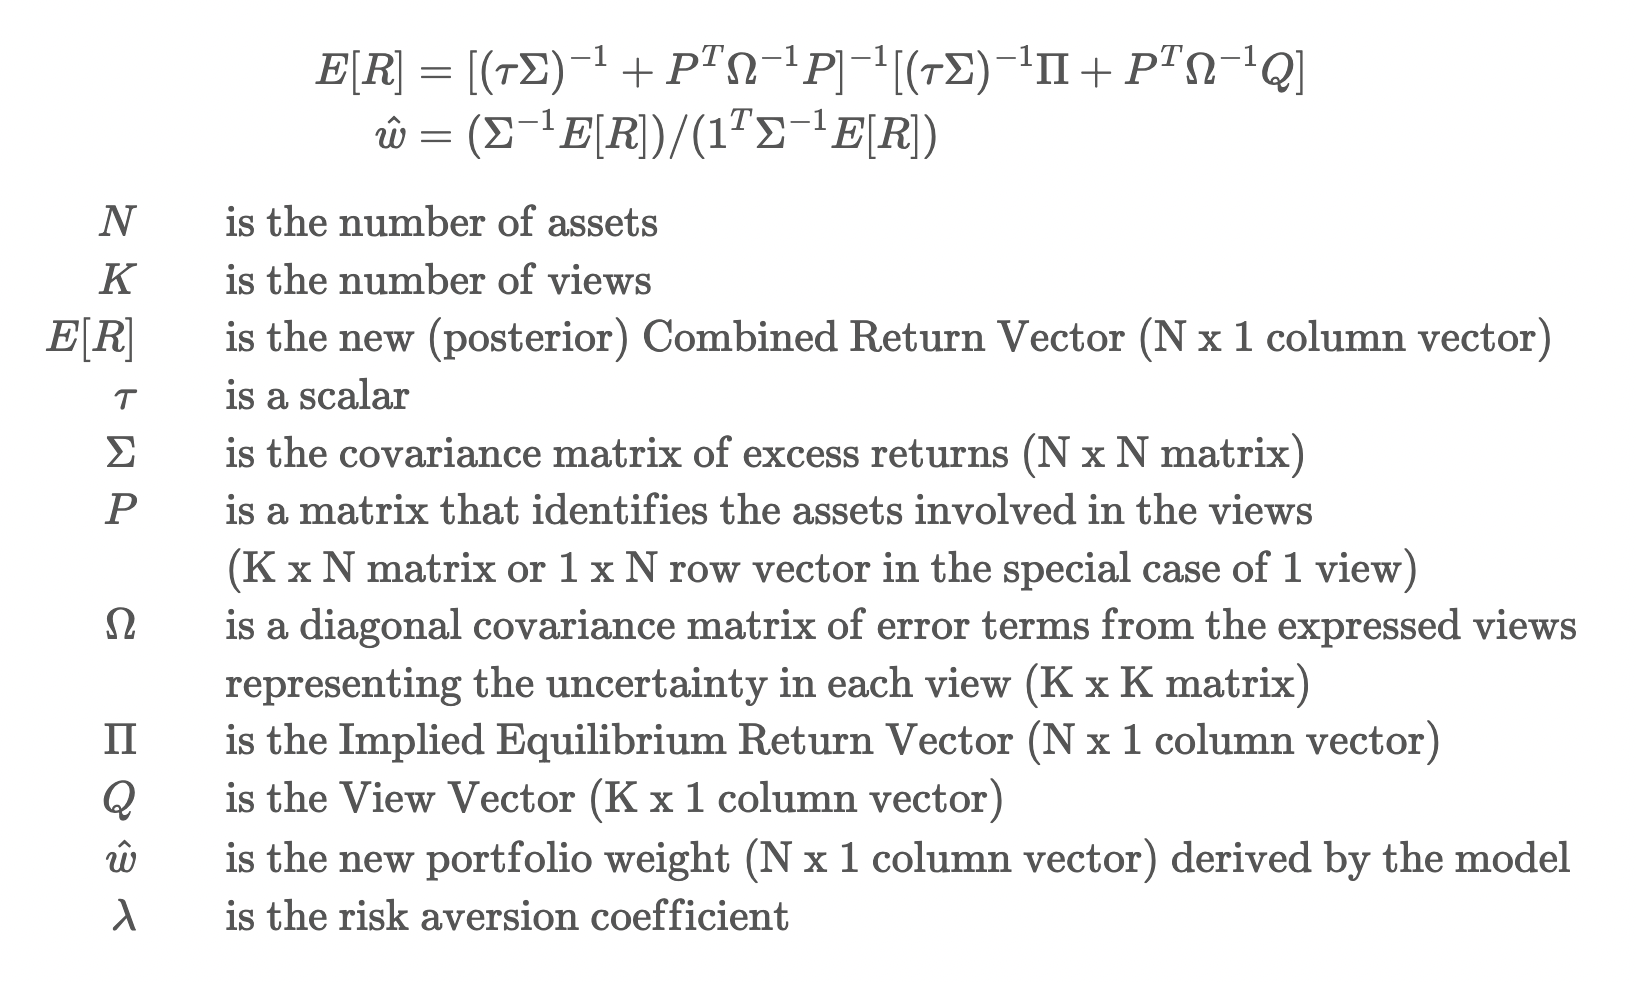

In [111]:
from numpy.linalg import inv

In [112]:
market_cap = market_cap_filter['market_cap']

In [113]:
market_weights = market_cap / market_cap.sum()

In [114]:
w_mkt = market_weights #투자 마켓 cap
monthly_excess_returns = train_returns.loc[:,train_returns.columns.isin(market_cap.index)] # 실제 시장 
N = monthly_excess_returns.columns.size #자산 수 
Sigma = monthly_excess_returns.cov()


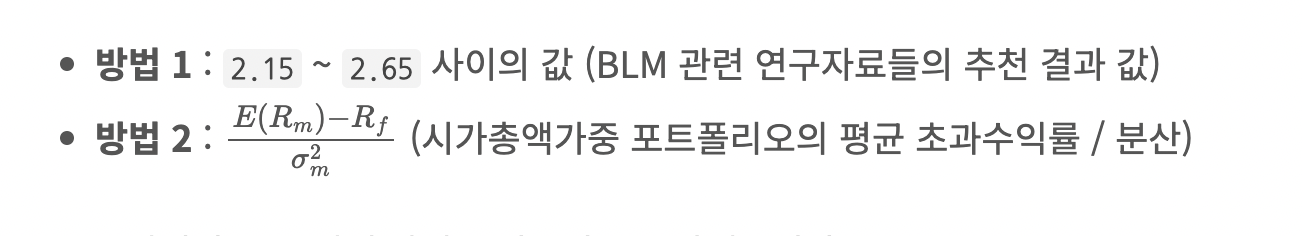

In [116]:
expected_portfolio_excess_return = monthly_excess_returns.mean().multiply(w_mkt).sum()
portfolio_variance = w_mkt.dot(Sigma).dot(w_mkt)
lambd = expected_portfolio_excess_return / portfolio_variance
Pi = lambd * Sigma.dot(w_mkt)

In [117]:
Pi = lambd * Sigma.dot(w_mkt)

In [118]:
Pi

000080    0.006787
000120    0.003156
000210    0.008662
000270    0.017946
000660    0.015013
            ...   
161890    0.013734
181710    0.010146
192080    0.008148
213500    0.010675
214320    0.008725
Length: 112, dtype: float64

In [119]:
K = len(monthly_excess_returns.columns)

In [120]:
mmonthly_df_price_factor

,000080,000120,000210,000270,000660,000720,000880,001430,001740,001800,...,122870,123420,139480,160550,161390,161890,181710,192080,213500,214320
Date,,,,,,,,,,,,,,,,,,,,,
2016-02,-0.010084,-0.111364,0.030774,0.021041,0.098901,0.035426,-0.069970,0.075099,0.095588,-0.109692,...,-0.152968,-0.180393,0.073171,0.103448,0.145923,-0.206897,0.140170,-0.104061,0.014182,0.008383
2016-03,-0.018676,-0.028133,0.130597,0.047722,-0.061667,0.109215,0.047215,0.011029,0.073826,-0.003286,...,0.053908,0.066988,-0.002841,0.361607,0.018727,0.009938,0.009181,-0.011340,0.023241,-0.041568
2016-04,-0.032872,0.023684,-0.002204,-0.008282,0.000000,-0.046256,0.064777,0.060000,0.060938,0.017506,...,0.094629,0.062783,0.045584,-0.190164,-0.023897,0.072571,0.100000,0.041551,0.122709,0.022305
2016-05,-0.101968,0.100257,-0.103638,-0.026096,0.019538,-0.149256,0.018520,-0.125214,-0.091311,0.043013,...,0.065421,-0.132666,-0.008174,-0.040486,-0.035782,0.055046,0.026458,0.111429,-0.010115,0.076364
2016-06,-0.049801,0.014019,-0.065188,-0.073955,0.128920,-0.024853,-0.080530,-0.025490,-0.037277,-0.028857,...,-0.119518,-0.134199,-0.049451,-0.012658,-0.003906,0.086957,0.038649,-0.058167,-0.086245,-0.086712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04,0.031863,0.067015,0.015209,0.070780,-0.048087,0.074242,0.011091,-0.026316,-0.144068,0.053571,...,-0.099788,-0.099556,-0.059084,-0.046131,0.090406,0.077253,-0.040486,0.058041,0.046602,0.053241
2024-05,-0.045131,-0.154160,0.037453,-0.002542,0.086108,-0.063470,-0.010969,0.027027,0.000000,0.010169,...,0.029481,-0.062192,-0.037677,-0.042122,-0.258037,0.280876,-0.073840,0.011429,0.021336,-0.043956
2024-06,0.057214,-0.082932,0.066787,0.098556,0.250000,-0.034639,-0.007394,-0.089912,-0.046535,0.020805,...,-0.076747,-0.049474,-0.078303,0.006515,0.030787,0.107309,-0.054670,0.041808,0.020890,-0.013793


In [121]:
import pandas as pd
import statsmodels.api as sm
mmonthly_fillter= mmonthly_df_price_factor.loc[:,mmonthly_df_price_factor.columns.isin(market_cap.index)]
mmonthly_fillter = mmonthly_fillter.iloc[15:,:]
train_size = int(len(mmonthly_fillter) * 0.5)

# 학습용 데이터 (50%)
train_returns = mmonthly_fillter.iloc[:train_size].shift(1).dropna()
train_factors = joined_df.iloc[:train_size].iloc[:-1,:]

# 테스트용 데이터 (50%)
test_returns = mmonthly_fillter.iloc[train_size:].shift(1).dropna()
test_factors = joined_df.iloc[train_size:].iloc[:-1,:]
# Function to perform OLS regression, predict returns, and return p-values
def ols_predict_with_pvalues(train_returns, train_factors, test_factors):
    predicted_df = pd.DataFrame(index=test_factors.index, columns=train_returns.columns)
    pvalues_df = pd.DataFrame(index=train_factors.columns.insert(0, 'const'), columns=train_returns.columns)
    
    train_returns, train_factors = train_returns.align(train_factors, join='inner', axis=0)

    # Perform regression for each asset
    for column in train_returns.columns:
        y_train = train_returns[column]
        X_train = sm.add_constant(train_factors)  # Adding constant
        
        # Train the OLS model
        model = sm.OLS(y_train, X_train).fit()
        
        # Store p-values
        pvalues_df[column] = model.pvalues
        
        # Predict for the test data
        X_test = sm.add_constant(test_factors, has_constant='add')
        predicted_df[column] = model.predict(X_test)
    
    return predicted_df, pvalues_df

# Execute the prediction with p-values
predicted_returns, pvalues_df = ols_predict_with_pvalues(train_returns, train_factors, test_factors)

# Display the resulting dataframes


In [122]:
def black_model(market_weights,monthly_excess_returns,Q,P,tau = 1):
    N = monthly_excess_returns.columns.size #자산 수 
    Sigma = monthly_excess_returns.cov()
    expected_portfolio_excess_return = monthly_excess_returns.mean().multiply(market_weights).sum()
    portfolio_variance = market_weights.dot(Sigma).dot(market_weights)
    lambd = expected_portfolio_excess_return / portfolio_variance
    Pi = lambd * Sigma.dot(market_weights)
    K = len(monthly_excess_returns.columns)
    assert Q.shape == (K,)
    P = np.eye(K)
    assert P.shape == (K, N)
    Omega = tau*P.dot(Sigma).dot(P.T) * np.eye(K)
    ER = Pi + tau*Sigma.dot(P.T).dot(inv(P.dot(tau*Sigma).dot(P.T) + Omega).dot(Q - P.dot(Pi)))
    w_hat = inv(Sigma).dot(ER)
    w_hat = pd.Series(w_hat / w_hat.sum(), index=monthly_excess_returns.columns)
    return ER,w_hat

In [123]:
Q = predicted_returns.iloc[-1,:].values
P = np.eye(K)
ER,w_hat = black_model(market_weights,monthly_excess_returns,Q,P)

In [125]:
from scipy import optimize

In [126]:
predicted_returns

,000080,000120,000210,000270,000660,000720,001430,001740,001800,002320,...,122870,123420,139480,160550,161390,161890,181710,192080,213500,214320
Date,,,,,,,,,,,,,,,,,,,,,
2021-01,0.038008,0.015884,-0.037310,-0.040502,0.011837,-0.046765,-0.002694,-0.077172,-0.015667,-0.012526,...,0.089778,-0.008583,-0.034091,0.014478,-0.008121,-0.039276,-0.047139,0.017921,0.007136,-0.012320
2021-02,0.004729,-0.024500,0.026110,0.001036,0.011545,-0.033003,-0.066201,0.035759,-0.032881,0.030961,...,-0.071921,0.023106,0.010988,-0.037463,-0.039322,0.001681,0.045080,0.005210,-0.046595,-0.021059
2021-03,0.011131,0.004073,-0.015904,-0.023606,0.009519,-0.030502,-0.033767,-0.039070,-0.018962,-0.015007,...,0.045959,0.002642,-0.019961,-0.009603,-0.020940,-0.016978,-0.006414,0.004444,-0.023615,-0.013428
2021-04,-0.003846,-0.007385,-0.021270,-0.058084,0.007056,-0.061500,-0.071935,-0.040356,-0.028226,-0.048653,...,0.035704,0.005390,-0.021315,-0.029957,-0.045395,-0.013358,0.005107,-0.005167,-0.067070,-0.034555
2021-05,0.024334,-0.035429,0.042593,0.029281,0.020724,-0.025923,-0.053944,0.071015,-0.041006,0.083067,...,-0.119492,0.028815,0.025007,-0.032548,-0.035767,0.003635,0.056910,0.019384,-0.021389,-0.013818
2021-06,0.064539,-0.004396,-0.030360,-0.024518,0.029160,-0.056220,-0.000220,-0.040668,-0.035766,0.037729,...,0.044311,-0.004497,-0.021972,0.017939,-0.016506,-0.037638,-0.032999,0.036180,0.027690,-0.012421
2021-07,0.023386,0.015293,-0.018519,0.032523,0.022870,0.027123,0.009568,-0.032640,-0.014471,0.019930,...,0.085783,-0.003819,-0.021255,0.016405,0.005251,-0.009022,-0.007380,0.013414,0.032989,0.020765
2021-08,-0.002757,-0.018007,0.013853,0.003021,0.013795,-0.019113,-0.063485,0.021117,-0.030772,0.011865,...,-0.031177,0.017687,0.002713,-0.033334,-0.036862,0.005761,0.042491,0.000123,-0.044759,-0.014899
2021-09,-0.037779,-0.002719,0.026786,0.041011,0.004531,0.039166,-0.060676,0.027086,-0.012153,-0.005661,...,-0.009174,0.020083,0.004588,-0.038688,-0.021442,0.026389,0.062091,-0.019599,-0.048808,0.006626


In [127]:
pvalues_df

,000080,000120,000210,000270,000660,000720,001430,001740,001800,002320,...,122870,123420,139480,160550,161390,161890,181710,192080,213500,214320
const,0.244235,0.452106,0.526374,0.011446,0.401244,0.228082,0.937197,0.803113,0.608960,0.120012,...,0.350239,0.787315,0.714137,0.903412,0.696346,0.760935,0.697681,0.594125,0.194178,0.185450
Market-RF,0.267823,0.446333,0.201939,0.000718,0.825451,0.030224,0.003888,0.194268,0.548079,0.028646,...,0.587578,0.957625,0.520427,0.463256,0.035353,0.917241,0.966001,0.569307,0.001531,0.024485
SMB,0.070681,0.329796,0.552329,0.520684,0.395925,0.234150,0.880379,0.709995,0.363937,0.362623,...,0.601071,0.942729,0.968735,0.812820,0.512030,0.670802,0.788099,0.441851,0.414971,0.563865
HML,0.307728,0.453133,0.214618,0.000537,0.789042,0.023370,0.004387,0.180815,0.562483,0.031527,...,0.660688,0.962225,0.527597,0.468469,0.037236,0.854554,0.967395,0.591422,0.001592,0.020826
senti_return,0.586513,0.243615,0.337131,0.844281,0.991185,0.562421,0.076412,0.081578,0.615266,0.816387,...,0.035530,0.743255,0.446751,0.520556,0.252967,0.648462,0.233105,0.881629,0.128203,0.400483


In [128]:
lambd = expected_portfolio_excess_return / portfolio_variance

In [129]:
lambd

6.139773567664533

In [130]:
windowsize = 30

In [131]:
pd.concat([train_returns,test_returns]).iloc[1+43-windowsize:1+43,:]

,000080,000120,000210,000270,000660,000720,001430,001740,001800,002320,...,122870,123420,139480,160550,161390,161890,181710,192080,213500,214320
Date,,,,,,,,,,,,,,,,,,,,,
2018-08,-0.073791,-0.101190,0.024824,0.027553,0.007001,0.017392,0.000000,0.045556,-0.176364,0.086817,...,-0.081379,-0.134241,-0.141454,-0.109661,0.054632,-0.192899,-0.032345,0.022342,0.095522,-0.070707
2018-09,-0.076923,0.019868,0.044648,0.011041,-0.038239,0.025633,-0.032634,-0.047821,-0.121413,0.280789,...,0.288288,0.040449,-0.018307,0.096774,0.050676,0.089443,-0.039806,0.269579,0.128065,0.057971
2018-10,0.002976,0.025974,0.008553,0.095164,-0.119277,0.125013,-0.060241,0.227679,-0.052764,0.102886,...,0.030303,-0.086393,-0.032634,-0.008021,0.073955,0.006729,0.014910,-0.010047,-0.024155,0.000000
2018-11,-0.065282,0.003165,-0.079905,-0.190883,-0.067031,-0.322218,-0.169231,-0.226364,-0.169761,0.145247,...,-0.166290,-0.193853,-0.014458,-0.388814,-0.173653,-0.275401,-0.250814,-0.055074,-0.138614,-0.006849
2018-12,0.111111,0.003155,0.247368,0.073944,0.020528,0.202184,0.030864,0.163337,0.092652,0.359140,...,0.177748,0.255132,-0.046455,0.080485,0.033816,0.263838,0.258435,-0.065945,-0.051724,0.162069
2019-01,-0.051429,0.050314,0.081214,0.104918,-0.130747,-0.007288,0.059880,0.050505,0.000000,0.056983,...,0.094470,-0.128505,-0.064103,-0.105102,-0.061916,0.029197,-0.006911,-0.018072,0.006061,-0.060831
2019-02,0.018072,0.005988,0.039030,0.078635,0.221488,0.139203,0.002825,0.140385,0.102339,-0.251869,...,-0.084211,0.179625,0.052055,0.070696,0.041096,-0.046809,0.029675,-0.065205,0.033133,0.113744
2019-03,0.047337,0.130952,-0.121131,0.005502,-0.052774,-0.080388,0.087324,-0.005059,0.010610,0.059642,...,-0.033333,0.063636,-0.062500,0.043663,0.022727,0.178571,0.254216,0.096603,0.037901,-0.008511
2019-04,0.045198,-0.128947,0.029913,-0.032832,0.060000,-0.066428,-0.007772,0.025424,-0.026247,-0.150068,...,-0.103448,0.012821,-0.044444,0.275510,-0.123977,0.005051,0.195953,0.001618,-0.171348,0.000000


In [132]:
pd.concat([train_returns,test_returns]).iloc[43-windowsize:43,:]

,000080,000120,000210,000270,000660,000720,001430,001740,001800,002320,...,122870,123420,139480,160550,161390,161890,181710,192080,213500,214320
Date,,,,,,,,,,,,,,,,,,,,,
2018-07,-0.024814,0.123746,-0.089284,-0.009631,-0.082441,-0.220862,-0.083333,-0.093656,0.148225,-0.130599,...,0.250000,-0.365432,0.018000,-0.129545,-0.017503,0.095979,-0.021136,-0.035893,-0.097035,-0.095890
2018-08,-0.073791,-0.101190,0.024824,0.027553,0.007001,0.017392,0.000000,0.045556,-0.176364,0.086817,...,-0.081379,-0.134241,-0.141454,-0.109661,0.054632,-0.192899,-0.032345,0.022342,0.095522,-0.070707
2018-09,-0.076923,0.019868,0.044648,0.011041,-0.038239,0.025633,-0.032634,-0.047821,-0.121413,0.280789,...,0.288288,0.040449,-0.018307,0.096774,0.050676,0.089443,-0.039806,0.269579,0.128065,0.057971
2018-10,0.002976,0.025974,0.008553,0.095164,-0.119277,0.125013,-0.060241,0.227679,-0.052764,0.102886,...,0.030303,-0.086393,-0.032634,-0.008021,0.073955,0.006729,0.014910,-0.010047,-0.024155,0.000000
2018-11,-0.065282,0.003165,-0.079905,-0.190883,-0.067031,-0.322218,-0.169231,-0.226364,-0.169761,0.145247,...,-0.166290,-0.193853,-0.014458,-0.388814,-0.173653,-0.275401,-0.250814,-0.055074,-0.138614,-0.006849
2018-12,0.111111,0.003155,0.247368,0.073944,0.020528,0.202184,0.030864,0.163337,0.092652,0.359140,...,0.177748,0.255132,-0.046455,0.080485,0.033816,0.263838,0.258435,-0.065945,-0.051724,0.162069
2019-01,-0.051429,0.050314,0.081214,0.104918,-0.130747,-0.007288,0.059880,0.050505,0.000000,0.056983,...,0.094470,-0.128505,-0.064103,-0.105102,-0.061916,0.029197,-0.006911,-0.018072,0.006061,-0.060831
2019-02,0.018072,0.005988,0.039030,0.078635,0.221488,0.139203,0.002825,0.140385,0.102339,-0.251869,...,-0.084211,0.179625,0.052055,0.070696,0.041096,-0.046809,0.029675,-0.065205,0.033133,0.113744
2019-03,0.047337,0.130952,-0.121131,0.005502,-0.052774,-0.080388,0.087324,-0.005059,0.010610,0.059642,...,-0.033333,0.063636,-0.062500,0.043663,0.022727,0.178571,0.254216,0.096603,0.037901,-0.008511


In [133]:
weight_list_BL = []
return_list_BL = []
weight_list_MV = []
return_list_MV = []
expected_list = []
import cvxpy as cp
from tqdm import tqdm
tau = 0.01# 명확한 기준은 없음 
window_size = 43
concat_df =pd.concat([train_returns,test_returns])
for i in tqdm(range(len(predicted_returns))):
    
    cofidence= np.array(1 - pvalues_df.iloc[-1,:])
    Sigma = train_returns.cov()
    implied_Omega = np.zeros((K, K))
    C = cofidence
    Q = predicted_returns.iloc[i,:].values
    expected_portfolio_excess_return = train_returns.mean().multiply(w_mkt).sum()
    portfolio_variance = w_mkt.dot(Sigma).dot(w_mkt)
    lambd = expected_portfolio_excess_return / portfolio_variance 
    # lambd = 2.65 #Risk Aversion Coefficient
    Pi = lambd * Sigma.dot(w_mkt)
    assert C.shape == (K,)
    for k in range(len(C)):
        ER_k_100 = Pi + tau*Sigma.dot(P[None, k].T).dot(inv(P[None, k].dot(tau * Sigma).dot(P[None, k].T)).dot(Q[None, k] - P[None, k].dot(Pi)))
        w_k_100 = inv(Sigma).dot(ER_k_100)
        w_k_100 = pd.Series(w_k_100 / w_k_100.sum(), index=predicted_returns.columns)
        w_k_implied = w_mkt + (w_k_100 - w_mkt) * C[k]
        def fun(omega_k):
            # 기존 ER을 구하는 수식에서 P를 P[None, k]로, Q를 Q[None, k]로 대체한 수식입니다.
            ER_k = Pi + tau * Sigma.dot(P[None, k].T).dot(inv(P[None, k].dot(tau * Sigma).dot(P[None, k].T) + omega_k).dot(Q[None, k] - P[None, k].dot(Pi)))
            
            w_k = inv(Sigma).dot(ER_k)
            w_k = pd.Series(w_k / w_k.sum(), index=predicted_returns.columns)
            
            diff = w_k_implied - w_k
            return diff.T.dot(diff)

        implied_Omega[k][k] = optimize.minimize_scalar(
            fun=fun,
            bounds=(1e-8, 1e+5),
            method='bounded',
        ).x
    ER_with_CL = Pi + tau * Sigma.dot(P.T).dot(inv(P.dot(tau * Sigma).dot(P.T) + implied_Omega).dot(Q - P.dot(Pi)))
    w_hat_with_CL = inv(Sigma).dot(ER_with_CL)
    w_hat_with_CL = pd.Series(w_hat_with_CL / w_hat_with_CL.sum(), index=predicted_returns.columns)
    weight_list_BL.append(w_hat_with_CL)
    return_list_BL.append(np.dot(w_hat_with_CL,test_returns.iloc[i,:]))

# ... (기존 코드)
    # ... (기존 코드)


    n_assets = len(ER_with_CL)
    w = cp.Variable(n_assets)

    # 기대 수익률과 공분산 행렬을 넘파이 배열로 변환합니다.
    mu = ER_with_CL.values  # numpy 배열로 변환
    Sigma_np = Sigma.values  # numpy 배열로 변환

    # 위험 회피 계수 (필요에 따라 조정 가능)
    delta = 1

    # 목적 함수: 기대 수익률 - 위험
    objective = cp.Maximize(mu @ w - delta * cp.quad_form(w, Sigma_np))

    # 제약 조건: 비중의 합은 1, 비중은 -1과 1 사이
    constraints = [cp.sum(w) == 1, w >= -1, w <= 1]

    # 최적화 문제를 정의하고 해결합니다.
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # 최적화된 비중을 얻습니다.
    w_hat_with_CL = pd.Series(w.value, index=predicted_returns.columns)

    # 이후 계산을 진행합니다.
    weight_list_MV.append(w_hat_with_CL)
    return_list_MV.append(np.dot(w_hat_with_CL, test_returns.iloc[i, :]))

# ... (이후 코드)

100%|██████████| 43/43 [03:07<00:00,  4.35s/it]


In [134]:
return_list_BL

[0.46653329755425305,
 0.4590738767845951,
 0.2728343638107726,
 0.6453807769572745,
 0.35930304175205585,
 -0.007882155750353172,
 -0.4707801159838755,
 -0.04909690346872616,
 0.1931004962611014,
 -0.24661741031512704,
 0.1523852716596088,
 -0.19698347354661347,
 -0.4979931175009921,
 -0.08862478916172874,
 -0.5306193179388059,
 0.5076880986609335,
 -0.5492280310087824,
 0.44184498410773954,
 0.1380044466092608,
 0.274899513623861,
 0.42592571155456244,
 -0.010070072587085555,
 0.2789617899050867,
 -0.20169609387781431,
 0.16879342776944,
 0.8754182784605435,
 0.38411231057350836,
 -0.10260507731581055,
 0.26537958740235484,
 -0.37636352685047963,
 0.21605275962031043,
 -0.3316423923633615,
 0.10867782544101844,
 0.0075429640720517084,
 -0.33732332148345145,
 0.03982988856345473,
 0.1260049387846254,
 1.1725861101707007,
 0.0037017017910586903,
 -0.12076372790312528,
 0.051710815725848944,
 -0.19511023450774856,
 -0.65505664302666]

In [135]:
portfolio_return_black = []
cumulative_value = 1 



for r in return_list_MV:
    cumulative_value *= (1 + r)
    portfolio_return_black.append(cumulative_value.copy())

                             Value
Max Drawdown             -0.562359
Volatility                0.112164
VaR (95%)                -0.153721
Expected Shortfall (95%) -0.180916
Sharpe Ratio              1.840581


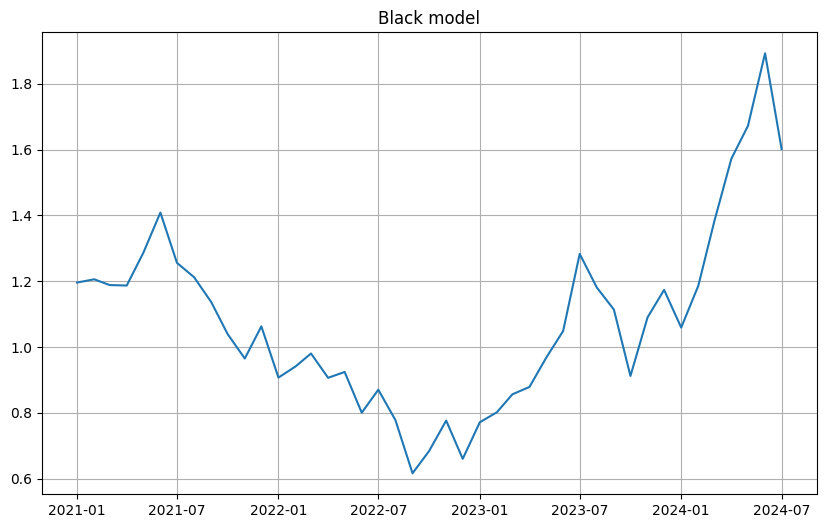

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


balance_series = pd.Series(portfolio_return_black)

# 최대 낙폭(MDD) 계산 함수
def max_drawdown(series):
    cumulative_max = series.cummax()
    drawdown = (series - cumulative_max) / cumulative_max
    return drawdown.min()

# 변동성 계산 함수
def volatility(series):
    daily_returns = series.pct_change().dropna()
    return daily_returns.std()

# VaR 계산 함수
def value_at_risk(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    return np.percentile(daily_returns, 100 * (1 - confidence_level))

# ES 계산 함수
def expected_shortfall(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    var = value_at_risk(series, confidence_level)
    return daily_returns[daily_returns <= var].mean()

# 샤프 비율 계산 함수
def sharpe_ratio(series, risk_free_rate=0.04):
    daily_returns = series.pct_change().dropna()
    excess_returns = daily_returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std() * np.sqrt(252)

# 견고성 지표 계산
mdd = max_drawdown(balance_series)
vol = volatility(balance_series)
var = value_at_risk(balance_series)
es = expected_shortfall(balance_series)
sharpe = sharpe_ratio(balance_series)

# 결과 출력
results = {
    "Max Drawdown": mdd,
    "Volatility": vol,
    "VaR (95%)": var,
    "Expected Shortfall (95%)": es,
    "Sharpe Ratio": sharpe
    
}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

# 결과 출력
print(results_df)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(predicted_returns.index.to_timestamp() ,balance_series.values)
plt.title('Black model')
plt.grid(True)
plt.show()

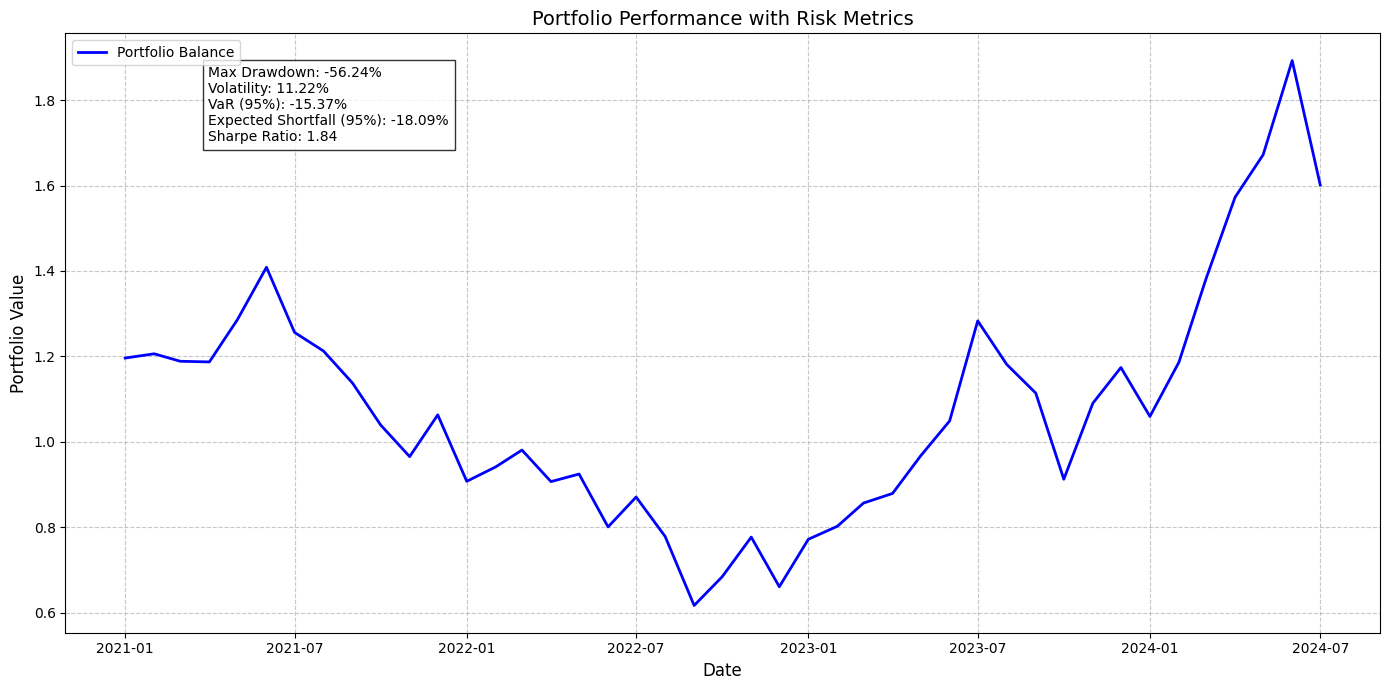

In [137]:
# MDD, VaR, ES 위치 찾기
mdd_end_idx = (balance_series.cummax() - balance_series).idxmax()
mdd_start_idx = balance_series[:mdd_end_idx].idxmax()

# 동일한 길이로 맞추기 위해 shift를 사용
daily_returns = balance_series.pct_change().dropna()
var_idx = daily_returns.index[daily_returns <= value_at_risk(balance_series, 0.95)].min()
es_idx = daily_returns.index[daily_returns <= expected_shortfall(balance_series, 0.95)].min()

# 그래프 그리기
plt.figure(figsize=(14, 7))
plt.plot(predicted_returns.index.to_timestamp(), balance_series.values, label='Portfolio Balance', color='blue', lw=2)
# plt.scatter(mdd_start_idx, balance_series[mdd_start_idx], color='red', label='MDD Start', zorder=5, s=100, marker='v')
# plt.scatter(mdd_end_idx, balance_series[mdd_end_idx], color='red', label='MDD End', zorder=5, s=100, marker='v')
# plt.axvline(var_idx, color='orange', linestyle='--', label='VaR (95%)', lw=1.5)
# plt.axvline(es_idx, color='green', linestyle='--', label='ES (95%)', lw=1.5)

# 그래프에 지표 텍스트 추가
plt.text(predicted_returns.index[int(len(balance_series) * 0.05)], max(balance_series) * 0.9,
         f'Max Drawdown: {mdd:.2%}\nVolatility: {vol:.2%}\nVaR (95%): {var:.2%}\nExpected Shortfall (95%): {es:.2%}\nSharpe Ratio: {sharpe:.2f}',
         fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

# 플롯 제목과 라벨
plt.title('Portfolio Performance with Risk Metrics', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# 그래프 표시
plt.tight_layout()
plt.show()

In [138]:
predicted_returns.index.to_timestamp() 

DatetimeIndex(['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01',
               '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01',
               '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
               '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01',
               '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
               '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01',
               '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01',
               '2024-05-01', '2024-06-01', '2024-07-01'],
              dtype='datetime64[ns]', name='Date', freq='MS')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


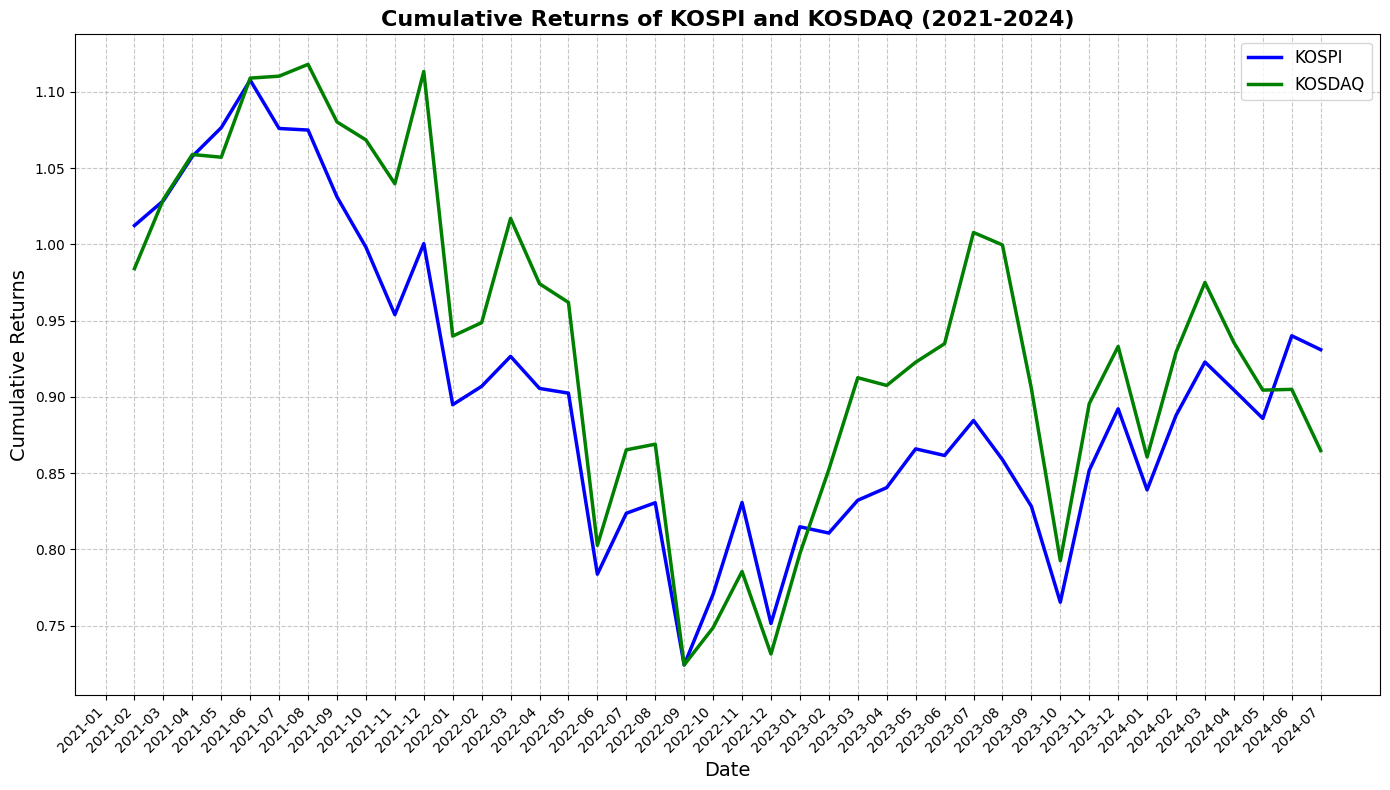

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

# 수집하려는 지수의 티커 심볼
tickers = {
    "KOSPI": "^KS11",     # 코스피
    "KOSDAQ": "^KQ11",    # 코스닥
    "S&P 500": "^GSPC"    # S&P 500
}

# 수집 기간 설정
start_date = "2021-01-01"
end_date = "2024-07-31"
date_range = pd.date_range(start=start_date, end=end_date, freq='MS')

# 각 티커에 대한 수익률 데이터를 가져와서 수익률을 계산
returns_data = pd.DataFrame(index=date_range.strftime('%Y-%m'))

for name, ticker in tickers.items():
    data = yf.download(ticker, start=start_date, end=end_date, interval="1mo")['Adj Close']
    monthly_returns = data.pct_change().dropna()  # 월별 수익률 계산
    returns_data[name] = monthly_returns

# 누적 수익률 계산
cumulative_returns = (1 + returns_data).cumprod()

# 플롯을 그리기
plt.figure(figsize=(14, 8))
plt.plot(cumulative_returns.index, cumulative_returns['KOSPI'], label='KOSPI', linewidth=2.5, color='blue')
plt.plot(cumulative_returns.index, cumulative_returns['KOSDAQ'], label='KOSDAQ', linewidth=2.5, color='green')
# plt.plot(cumulative_returns.index, cumulative_returns['S&P 500'], label='S&P 500', linewidth=2.5, color='red')

# 스타일 지정
plt.title("Cumulative Returns of KOSPI and KOSDAQ (2021-2024)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cumulative Returns", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 결과 출력
plt.show()

                             Value
Max Drawdown             -0.346163
Volatility                0.055602
VaR (95%)                -0.105556
Expected Shortfall (95%) -0.121712
Sharpe Ratio             -0.187896


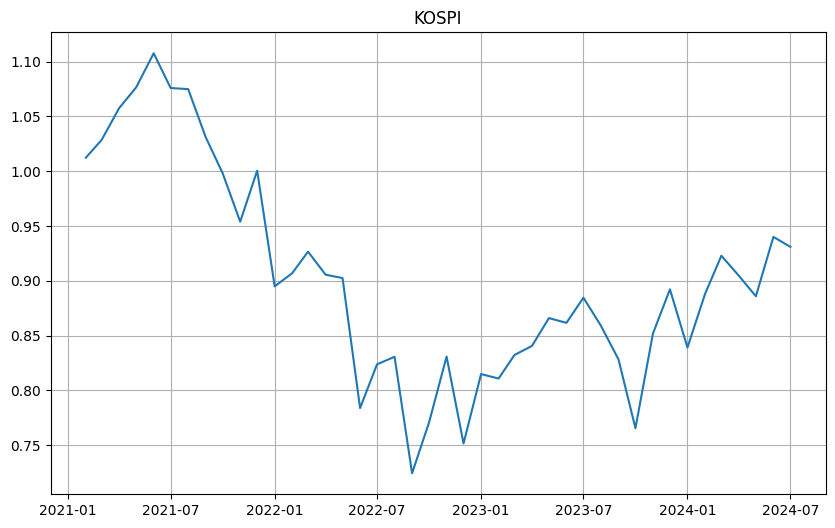

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


balance_series = pd.Series(cumulative_returns['KOSPI'])

# 최대 낙폭(MDD) 계산 함수
def max_drawdown(series):
    cumulative_max = series.cummax()
    drawdown = (series - cumulative_max) / cumulative_max
    return drawdown.min()

# 변동성 계산 함수
def volatility(series):
    daily_returns = series.pct_change().dropna()
    return daily_returns.std()

# VaR 계산 함수
def value_at_risk(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    return np.percentile(daily_returns, 100 * (1 - confidence_level))

# ES 계산 함수
def expected_shortfall(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    var = value_at_risk(series, confidence_level)
    return daily_returns[daily_returns <= var].mean()

# 샤프 비율 계산 함수
def sharpe_ratio(series, risk_free_rate=0.04):
    daily_returns = series.pct_change().dropna()
    excess_returns = daily_returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std() * np.sqrt(252)

# 견고성 지표 계산
mdd = max_drawdown(balance_series)
vol = volatility(balance_series)
var = value_at_risk(balance_series)
es = expected_shortfall(balance_series)
sharpe = sharpe_ratio(balance_series)

# 결과 출력
results = {
    "Max Drawdown": mdd,
    "Volatility": vol,
    "VaR (95%)": var,
    "Expected Shortfall (95%)": es,
    "Sharpe Ratio": sharpe
    
}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

# 결과 출력
print(results_df)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(predicted_returns.index.to_timestamp() ,balance_series.values)
plt.title('KOSPI')
plt.grid(True)
plt.show()

                             Value
Max Drawdown             -0.352181
Volatility                0.070801
VaR (95%)                -0.155815
Expected Shortfall (95%) -0.162638
Sharpe Ratio             -0.170246


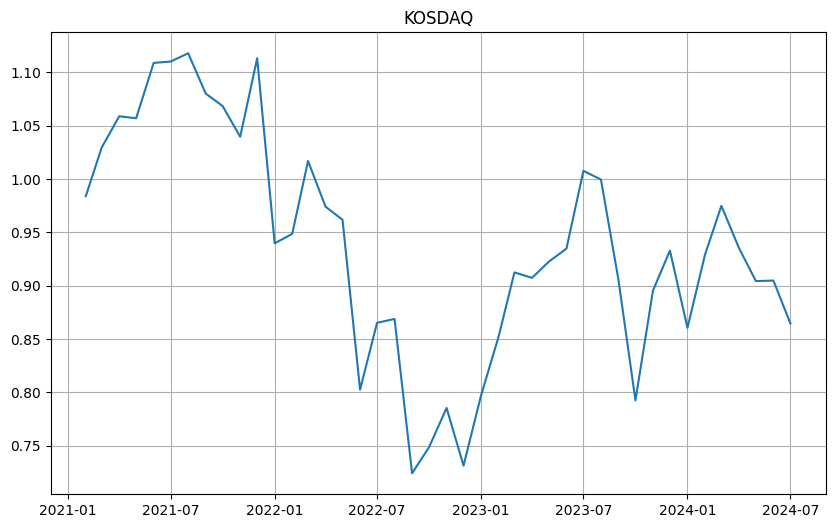

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


balance_series = pd.Series(cumulative_returns['KOSDAQ'])

# 최대 낙폭(MDD) 계산 함수
def max_drawdown(series):
    cumulative_max = series.cummax()
    drawdown = (series - cumulative_max) / cumulative_max
    return drawdown.min()

# 변동성 계산 함수
def volatility(series):
    daily_returns = series.pct_change().dropna()
    return daily_returns.std()

# VaR 계산 함수
def value_at_risk(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    return np.percentile(daily_returns, 100 * (1 - confidence_level))

# ES 계산 함수
def expected_shortfall(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    var = value_at_risk(series, confidence_level)
    return daily_returns[daily_returns <= var].mean()

# 샤프 비율 계산 함수
def sharpe_ratio(series, risk_free_rate=0.04):
    daily_returns = series.pct_change().dropna()
    excess_returns = daily_returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std() * np.sqrt(252)

# 견고성 지표 계산
mdd = max_drawdown(balance_series)
vol = volatility(balance_series)
var = value_at_risk(balance_series)
es = expected_shortfall(balance_series)
sharpe = sharpe_ratio(balance_series)

# 결과 출력
results = {
    "Max Drawdown": mdd,
    "Volatility": vol,
    "VaR (95%)": var,
    "Expected Shortfall (95%)": es,
    "Sharpe Ratio": sharpe
    
}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

# 결과 출력
print(results_df)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(predicted_returns.index.to_timestamp() ,balance_series.values)
plt.title('KOSDAQ')
plt.grid(True)
plt.show()

                             Value
Max Drawdown             -0.247695
Volatility                0.048976
VaR (95%)                -0.083920
Expected Shortfall (95%) -0.088424
Sharpe Ratio              3.275148


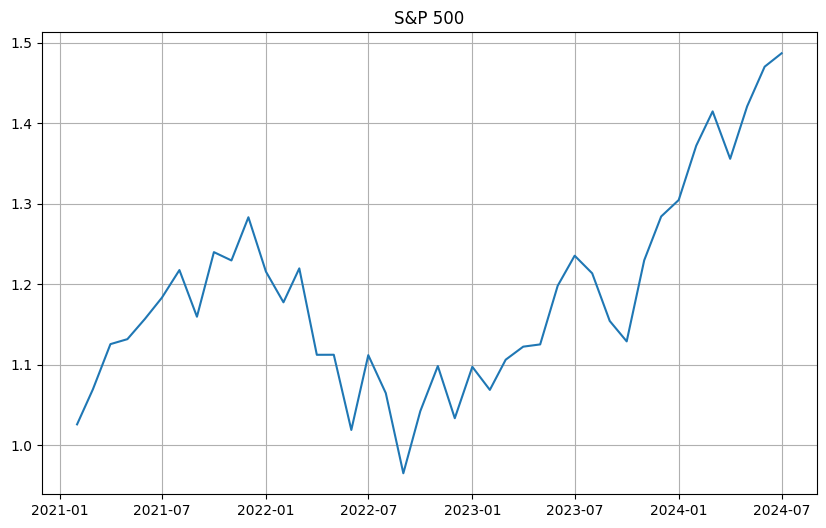

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


balance_series = pd.Series(cumulative_returns['S&P 500'])

# 최대 낙폭(MDD) 계산 함수
def max_drawdown(series):
    cumulative_max = series.cummax()
    drawdown = (series - cumulative_max) / cumulative_max
    return drawdown.min()

# 변동성 계산 함수
def volatility(series):
    daily_returns = series.pct_change().dropna()
    return daily_returns.std()

# VaR 계산 함수
def value_at_risk(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    return np.percentile(daily_returns, 100 * (1 - confidence_level))

# ES 계산 함수
def expected_shortfall(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    var = value_at_risk(series, confidence_level)
    return daily_returns[daily_returns <= var].mean()

# 샤프 비율 계산 함수
def sharpe_ratio(series, risk_free_rate=0.04):
    daily_returns = series.pct_change().dropna()
    excess_returns = daily_returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std() * np.sqrt(252)

# 견고성 지표 계산
mdd = max_drawdown(balance_series)
vol = volatility(balance_series)
var = value_at_risk(balance_series)
es = expected_shortfall(balance_series)
sharpe = sharpe_ratio(balance_series)

# 결과 출력
results = {
    "Max Drawdown": mdd,
    "Volatility": vol,
    "VaR (95%)": var,
    "Expected Shortfall (95%)": es,
    "Sharpe Ratio": sharpe
    
}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

# 결과 출력
print(results_df)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(predicted_returns.index.to_timestamp() ,balance_series.values)
plt.title('S&P 500')
plt.grid(True)
plt.show()

---

In [ ]:
mmonthly_fillter

,000080,000120,000210,000270,000660,000720,001430,001740,001800,002320,...,122870,123420,139480,160550,161390,161890,181710,192080,213500,214320
Date,,,,,,,,,,,,,,,,,,,,,
2017-05,0.157895,0.156156,0.150689,0.120516,0.055556,0.003091,0.019713,-0.076155,0.180474,0.009861,...,0.145695,-0.071429,0.056522,0.060255,0.033956,0.063512,0.138260,0.001832,0.031746,0.028169
2017-06,-0.037190,-0.062338,-0.036793,-0.021767,0.182456,-0.054428,0.073814,-0.155405,0.000000,0.200672,...,-0.089595,-0.067308,-0.034979,-0.076503,0.044335,-0.154567,0.134165,0.123852,-0.012821,-0.028919
2017-07,0.027897,0.033241,0.030328,-0.041885,-0.020772,-0.016271,0.140753,0.012800,-0.295918,-0.142649,...,-0.063492,-0.064433,0.083156,-0.047337,-0.017296,-0.016620,-0.044811,0.021072,-0.012987,0.070533
2017-08,0.089770,-0.093834,-0.086144,-0.031421,0.039394,-0.102664,0.017217,0.107425,-0.003623,-0.031719,...,-0.067797,-0.002755,-0.118110,-0.108075,-0.056000,-0.043662,-0.164284,-0.152371,-0.039474,0.049780
2017-09,0.007663,-0.032544,-0.044148,-0.107193,0.208455,-0.056560,-0.112835,0.028531,-0.174545,-0.021277,...,-0.010909,0.060773,-0.069196,-0.033426,0.020339,0.116348,0.065526,0.058048,-0.087671,-0.066946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04,0.031863,0.067015,0.015209,0.070780,-0.048087,0.074242,-0.026316,-0.144068,0.053571,-0.062921,...,-0.099788,-0.099556,-0.059084,-0.046131,0.090406,0.077253,-0.040486,0.058041,0.046602,0.053241
2024-05,-0.045131,-0.154160,0.037453,-0.002542,0.086108,-0.063470,0.027027,0.000000,0.010169,-0.075779,...,0.029481,-0.062192,-0.037677,-0.042122,-0.258037,0.280876,-0.073840,0.011429,0.021336,-0.043956
2024-06,0.057214,-0.082932,0.066787,0.098556,0.250000,-0.034639,-0.089912,-0.046535,0.020805,0.016087,...,-0.076747,-0.049474,-0.078303,0.006515,0.030787,0.107309,-0.054670,0.041808,0.020890,-0.013793


In [ ]:
n_assets = len(mmonthly_fillter.columns)
w = cp.Variable(n_assets)
start = int(len(mmonthly_fillter)*0.5)
weight_list_MV_basic = []
return_list_MV_basic = []
for i in range(len(mmonthly_fillter)-start-1):

    mmonthly_fillter.iloc[i:i+start,:].mean()
    # 기대 수익률과 공분산 행렬을 넘파이 배열로 변환합니다.
    mu = mmonthly_fillter.iloc[i:i+start,:].mean().values # numpy 배열로 변환
    Sigma_np = mmonthly_fillter.iloc[i:i+start,:].cov() # numpy 배열로 변환

    # 위험 회피 계수 (필요에 따라 조정 가능)
    delta = 1

    # 목적 함수: 기대 수익률 - 위험
    objective = cp.Maximize(mu.T @ w - delta * cp.quad_form(w, Sigma_np))

    # 제약 조건: 비중의 합은 1, 비중은 -1과 1 사이
    constraints = [cp.sum(w) == 1, w >= 0, w <= 1]

    # 최적화 문제를 정의하고 해결합니다.
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # 최적화된 비중을 얻습니다.
    w_hat_with_CL = pd.Series(w.value, index=predicted_returns.columns)
    weight_list_MV_basic.append(w_hat_with_CL)
    return_list_MV_basic.append(np.dot(w_hat_with_CL, mmonthly_fillter.iloc[i+start, :]))

In [ ]:
portfolio_return_basic = []

cumulative_value = 1 



for r in return_list_MV_basic:
    cumulative_value *= (1 + r)
    portfolio_return_basic.append(cumulative_value.copy())

                             Value
Max Drawdown             -0.787841
Volatility                0.111153
VaR (95%)                -0.193102
Expected Shortfall (95%) -0.240516
Sharpe Ratio             -4.007360


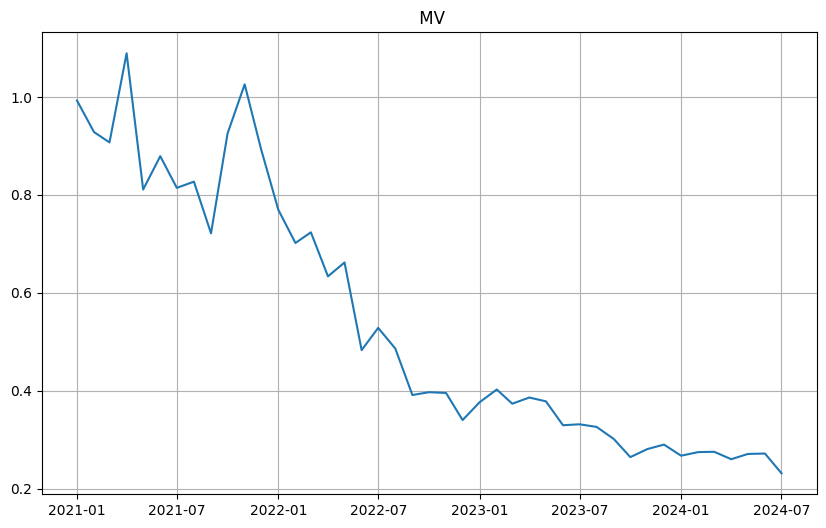

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


balance_series = pd.Series(portfolio_return_basic)

# 최대 낙폭(MDD) 계산 함수
def max_drawdown(series):
    cumulative_max = series.cummax()
    drawdown = (series - cumulative_max) / cumulative_max
    return drawdown.min()

# 변동성 계산 함수
def volatility(series):
    daily_returns = series.pct_change().dropna()
    return daily_returns.std()

# VaR 계산 함수
def value_at_risk(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    return np.percentile(daily_returns, 100 * (1 - confidence_level))

# ES 계산 함수
def expected_shortfall(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    var = value_at_risk(series, confidence_level)
    return daily_returns[daily_returns <= var].mean()

# 샤프 비율 계산 함수
def sharpe_ratio(series, risk_free_rate=0.04):
    daily_returns = series.pct_change().dropna()
    excess_returns = daily_returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std() * np.sqrt(252)

# 견고성 지표 계산
mdd = max_drawdown(balance_series)
vol = volatility(balance_series)
var = value_at_risk(balance_series)
es = expected_shortfall(balance_series)
sharpe = sharpe_ratio(balance_series)

# 결과 출력
results = {
    "Max Drawdown": mdd,
    "Volatility": vol,
    "VaR (95%)": var,
    "Expected Shortfall (95%)": es,
    "Sharpe Ratio": sharpe
    
}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

# 결과 출력
print(results_df)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(predicted_returns.index.to_timestamp() ,balance_series.values)
plt.title(' MV')
plt.grid(True)
plt.show()

In [ ]:
n_assets = len(mmonthly_fillter.columns)
w = cp.Variable(n_assets)
start = int(len(mmonthly_fillter)*0.5)
weight_list_MV_1 = []
return_list_MV_1 = []
for i in range(len(mmonthly_fillter)-start-1):

    mmonthly_fillter.iloc[i:i+start,:].mean()
    # 기대 수익률과 공분산 행렬을 넘파이 배열로 변환합니다.
    mu = predicted_returns.iloc[i,:].values
    # mu = mmonthly_fillter.iloc[i:i+start,:].mean().values # numpy 배열로 변환
    Sigma_np = mmonthly_fillter.iloc[i:i+start,:].cov() # numpy 배열로 변환

    # 위험 회피 계수 (필요에 따라 조정 가능)
    delta = 1

    # 목적 함수: 기대 수익률 - 위험
    objective = cp.Maximize(mu.T @ w - delta * cp.quad_form(w, Sigma_np))

    # 제약 조건: 비중의 합은 1, 비중은 -1과 1 사이
    constraints = [cp.sum(w) == 1, w >= 0, w <= 1]

    # 최적화 문제를 정의하고 해결합니다.
    prob = cp.Problem(objective, constraints)
    prob.solve()

    # 최적화된 비중을 얻습니다.
    w_hat_with_CL = pd.Series(w.value, index=predicted_returns.columns)
    weight_list_MV_1.append(w_hat_with_CL)
    return_list_MV_1.append(np.dot(w_hat_with_CL, mmonthly_fillter.iloc[i+start+1, :]))

In [ ]:
portfolio_return_factor = []

cumulative_value = 1 



for r in return_list_MV_1:
    cumulative_value *= (1 + r)
    portfolio_return_factor.append(cumulative_value.copy())

                             Value
Max Drawdown             -0.498973
Volatility                0.101507
VaR (95%)                -0.166031
Expected Shortfall (95%) -0.175954
Sharpe Ratio             -0.874586


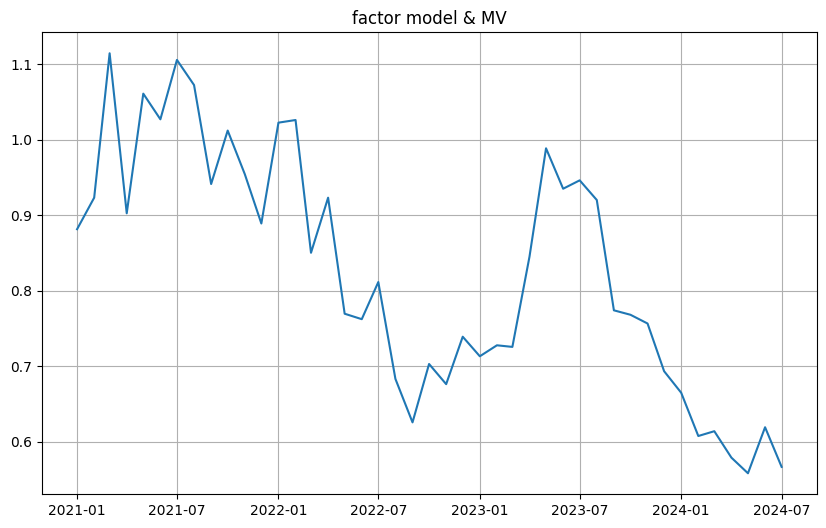

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


balance_series = pd.Series(portfolio_return_factor)

# 최대 낙폭(MDD) 계산 함수
def max_drawdown(series):
    cumulative_max = series.cummax()
    drawdown = (series - cumulative_max) / cumulative_max
    return drawdown.min()

# 변동성 계산 함수
def volatility(series):
    daily_returns = series.pct_change().dropna()
    return daily_returns.std()

# VaR 계산 함수
def value_at_risk(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    return np.percentile(daily_returns, 100 * (1 - confidence_level))

# ES 계산 함수
def expected_shortfall(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    var = value_at_risk(series, confidence_level)
    return daily_returns[daily_returns <= var].mean()

# 샤프 비율 계산 함수
def sharpe_ratio(series, risk_free_rate=0.04):
    daily_returns = series.pct_change().dropna()
    excess_returns = daily_returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std() * np.sqrt(252)

# 견고성 지표 계산
mdd = max_drawdown(balance_series)
vol = volatility(balance_series)
var = value_at_risk(balance_series)
es = expected_shortfall(balance_series)
sharpe = sharpe_ratio(balance_series)

# 결과 출력
results = {
    "Max Drawdown": mdd,
    "Volatility": vol,
    "VaR (95%)": var,
    "Expected Shortfall (95%)": es,
    "Sharpe Ratio": sharpe
    
}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

# 결과 출력
print(results_df)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(predicted_returns.index.to_timestamp() ,balance_series.values)
plt.title('factor model & MV')
plt.grid(True)
plt.show()

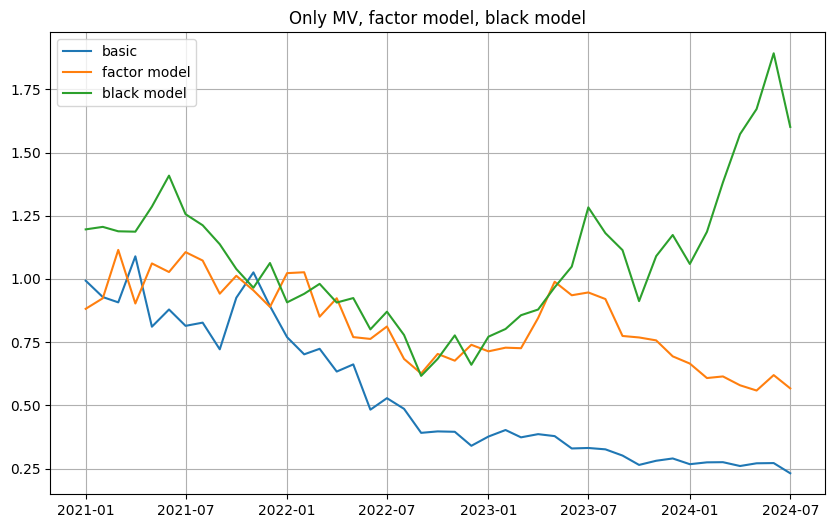

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(predicted_returns.index.to_timestamp() ,portfolio_return_basic,label = 'basic')
plt.plot(predicted_returns.index.to_timestamp() ,portfolio_return_factor,label = 'factor model')
plt.plot(predicted_returns.index.to_timestamp() ,portfolio_return_black,label = 'black model')
plt.legend()
plt.title('Only MV, factor model, black model')
plt.grid(True)
plt.show()

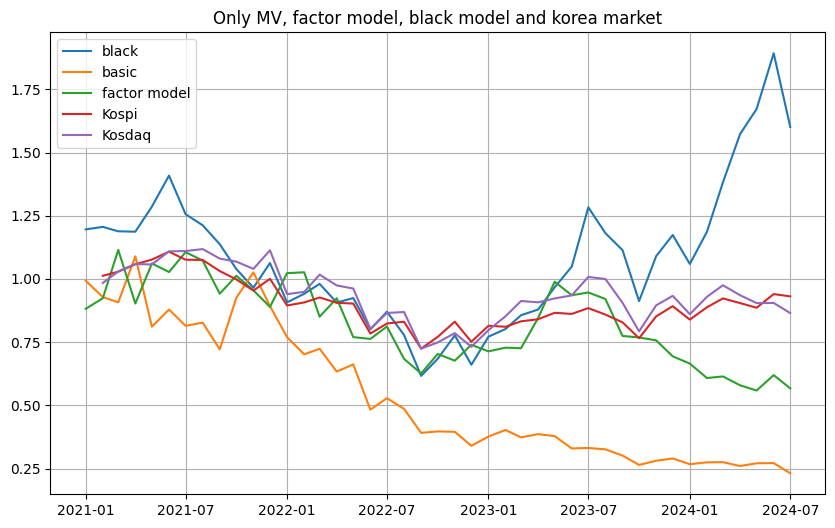

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(predicted_returns.index.to_timestamp() ,portfolio_return_black,label = 'black')
plt.plot(predicted_returns.index.to_timestamp() ,portfolio_return_basic,label = 'basic')
plt.plot(predicted_returns.index.to_timestamp() ,portfolio_return_factor,label = 'factor model')
plt.plot(predicted_returns.index.to_timestamp() ,cumulative_returns['KOSPI'],label = 'Kospi')
plt.plot(predicted_returns.index.to_timestamp() ,cumulative_returns['KOSDAQ'],label = 'Kosdaq')
plt.legend()
plt.title('Only MV, factor model, black model and korea market')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


balance_series = pd.Series(portfolio_return)

# 최대 낙폭(MDD) 계산 함수
def max_drawdown(series):
    cumulative_max = series.cummax()
    drawdown = (series - cumulative_max) / cumulative_max
    return drawdown.min()

# 변동성 계산 함수
def volatility(series):
    daily_returns = series.pct_change().dropna()
    return daily_returns.std()

# VaR 계산 함수
def value_at_risk(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    return np.percentile(daily_returns, 100 * (1 - confidence_level))

# ES 계산 함수
def expected_shortfall(series, confidence_level=0.95):
    daily_returns = series.pct_change().dropna()
    var = value_at_risk(series, confidence_level)
    return daily_returns[daily_returns <= var].mean()

# 샤프 비율 계산 함수
def sharpe_ratio(series, risk_free_rate=0.04):
    daily_returns = series.pct_change().dropna()
    excess_returns = daily_returns - risk_free_rate / 252
    return excess_returns.mean() / excess_returns.std() * np.sqrt(252)

# 견고성 지표 계산
mdd = max_drawdown(balance_series)
vol = volatility(balance_series)
var = value_at_risk(balance_series)
es = expected_shortfall(balance_series)
sharpe = sharpe_ratio(balance_series)

# 결과 출력
results = {
    "Max Drawdown": mdd,
    "Volatility": vol,
    "VaR (95%)": var,
    "Expected Shortfall (95%)": es,
    "Sharpe Ratio": sharpe
    
}
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Value'])

# 결과 출력
print(results_df)

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(predicted_returns.index.to_timestamp() ,balance_series.values)
plt.title('factor model & MV')
plt.grid(True)
plt.show()

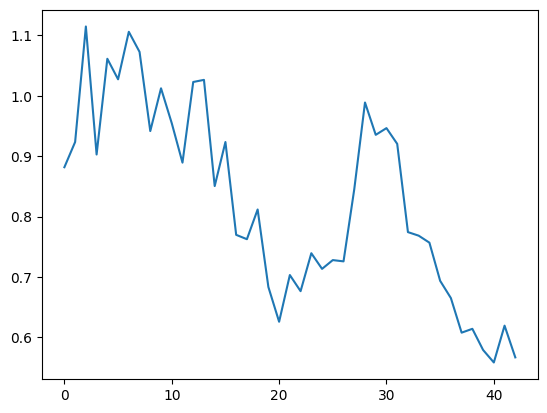

In [ ]:
plt.plot(portfolio_return)